In [ ]:
#DATASET PREPARATION CODE 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Load data ---
df = pd.read_csv('dataset path')

# --- Drop ID column ---
df.drop(columns=['customerID'], inplace=True)

# --- Fix TotalCharges: convert to numeric, drop 11 bad rows ---
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# --- Encode outcome variable ---
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# --- Encode binary categorical variables ---
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = (df[col] == 'Yes').astype(int)
# gender: Female=0, Male=1
df['gender'] = (df['gender'] == 'Male').astype(int)

# --- One-hot encode multi-category variables ---
multi_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)

# --- Split features and outcome ---
X = df.drop(columns=['Churn'])
y = df['Churn']

# --- Train/test split (80/20, stratified to preserve class balance) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Scale numeric features for Logistic Regression ---
scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# X_train_scaled / X_test_scaled → use for Logistic Regression
# X_train / X_test (unscaled) → use for Random Forest

In [3]:
# Confirm everything looks right
print("Shape after cleaning:", X_train.shape)
print("\nFeature names sample:", list(X.columns[:10]))
print("\nClass balance in training set:\n", y_train.value_counts(normalize=True).round(2))
print("\nScaled numeric features (first 3 rows):\n", X_train_scaled[['tenure','MonthlyCharges','TotalCharges']].head(3))
print("\nAny nulls remaining?", df.isnull().sum().sum())

Shape after cleaning: (5625, 30)

Feature names sample: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No phone service']

Class balance in training set:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64

Scaled numeric features (first 3 rows):
         tenure  MonthlyCharges  TotalCharges
1413  1.321816        0.981556      1.659900
7003 -0.267410       -0.971546     -0.562252
3355  1.444064        0.837066      1.756104

Any nulls remaining? 0


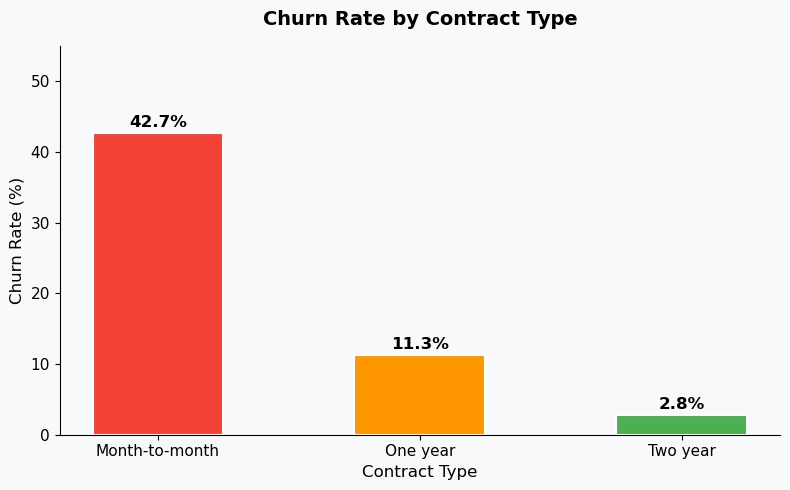

EDA 1 saved.


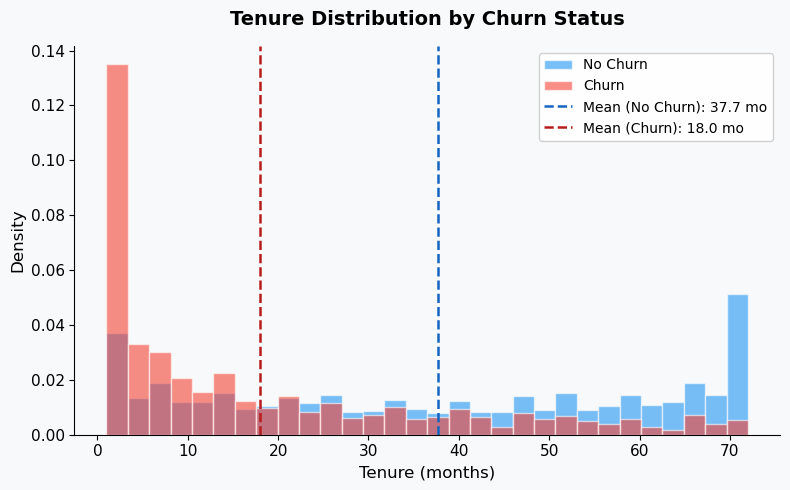

EDA 2 saved.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- Load and clean data ---
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df['Churn_binary'] = (df['Churn'] == 'Yes').astype(int)

# ── EDA 1: Churn Rate by Contract Type ───────────────────────────────────────
fig1, ax1 = plt.subplots(figsize=(8, 5))
fig1.patch.set_facecolor('#f8f9fa')
ax1.set_facecolor('#f8f9fa')

contract_churn = df.groupby('Contract')['Churn_binary'].mean().sort_values(ascending=False)
colors = ['#F44336', '#FF9800', '#4CAF50']  # red=high churn, green=low churn

bars = ax1.bar(contract_churn.index, contract_churn.values * 100,
               color=colors, edgecolor='white', linewidth=1.5, width=0.5)

# Add percentage labels on top of each bar
for bar, val in zip(bars, contract_churn.values):
    ax1.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.8,
             f'{val * 100:.1f}%',
             ha='center', fontweight='bold', fontsize=12)

ax1.set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Contract Type', fontsize=12)
ax1.set_ylabel('Churn Rate (%)', fontsize=12)
ax1.set_ylim(0, 55)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig('eda1_churn_by_contract.png', dpi=150, bbox_inches='tight')
plt.show()
print("EDA 1 saved.")

# ── EDA 2: Tenure Distribution by Churn ──────────────────────────────────────
fig2, ax2 = plt.subplots(figsize=(8, 5))
fig2.patch.set_facecolor('#f8f9fa')
ax2.set_facecolor('#f8f9fa')

# Plot both groups as overlapping histograms
ax2.hist(df[df['Churn'] == 'No']['tenure'],
         bins=30, color='#2196F3', alpha=0.6,
         label='No Churn', density=True, edgecolor='white')

ax2.hist(df[df['Churn'] == 'Yes']['tenure'],
         bins=30, color='#F44336', alpha=0.6,
         label='Churn', density=True, edgecolor='white')

# Add mean lines for each group
mean_no = df[df['Churn'] == 'No']['tenure'].mean()
mean_yes = df[df['Churn'] == 'Yes']['tenure'].mean()

ax2.axvline(mean_no, color='#1565C0', linestyle='--', linewidth=1.8,
            label=f'Mean (No Churn): {mean_no:.1f} mo')
ax2.axvline(mean_yes, color='#B71C1C', linestyle='--', linewidth=1.8,
            label=f'Mean (Churn): {mean_yes:.1f} mo')

ax2.set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Tenure (months)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend(fontsize=10, framealpha=0.9)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig('eda2_tenure_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("EDA 2 saved.")

LOGISTIC REGRESSION
Accuracy:  0.8045
ROC-AUC:   0.8361

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1033
       Churn       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

RANDOM FOREST
Accuracy:  0.7861
ROC-AUC:   0.8159

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.88      0.86      1033
       Churn       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



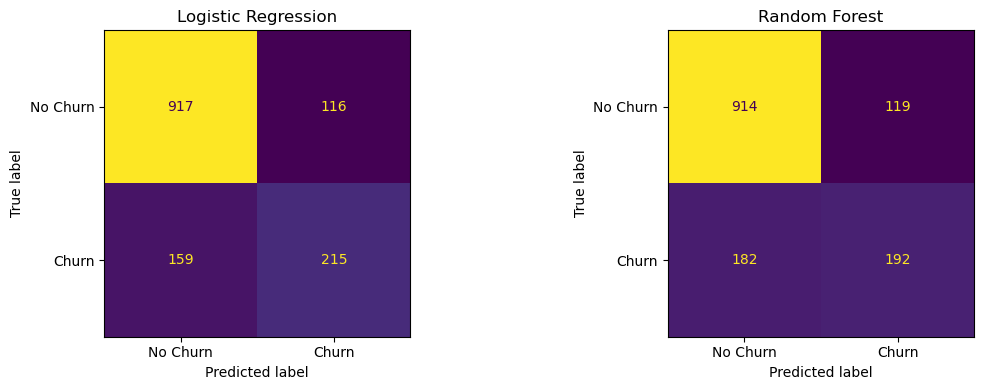

Confusion matrix saved.


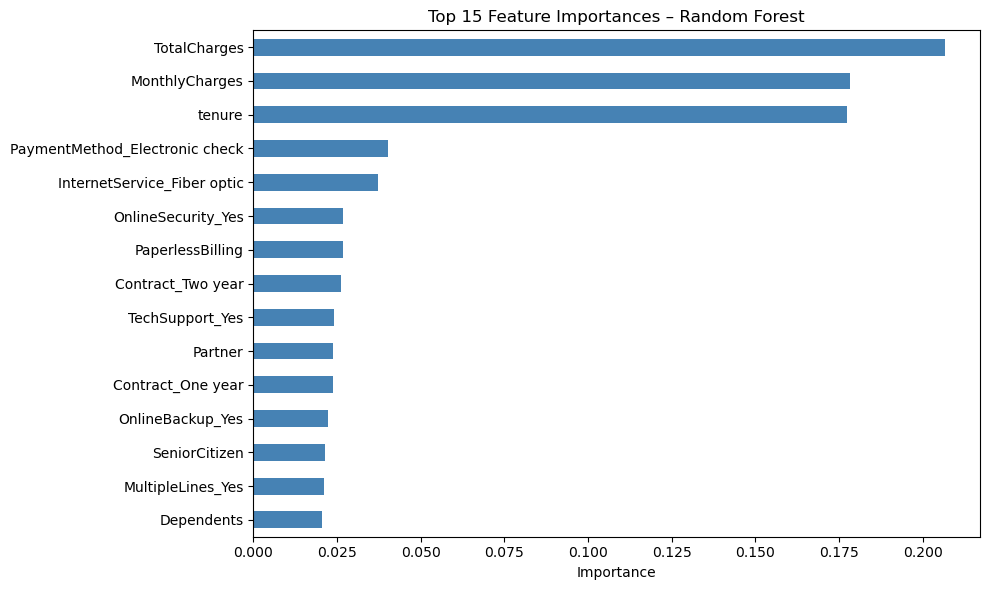

Feature importance plot saved.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# ── 1. LOGISTIC REGRESSION ───────────────────────────────────────────────────
# Use scaled data; max_iter increased to ensure convergence
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# ── 2. RANDOM FOREST ─────────────────────────────────────────────────────────
# Use unscaled data; tree-based models don't need scaling
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# ── 3. COMPARE PERFORMANCE ───────────────────────────────────────────────────
print("=" * 50)
print("LOGISTIC REGRESSION")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))

print("=" * 50)
print("RANDOM FOREST")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

# ── 4. CONFUSION MATRICES ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr, display_labels=['No Churn', 'Churn'],
    ax=axes[0], colorbar=False)
axes[0].set_title('Logistic Regression')

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=['No Churn', 'Churn'],
    ax=axes[1], colorbar=False)
axes[1].set_title('Random Forest')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()
print("Confusion matrix saved.")

# ── 5. FEATURE IMPORTANCE (Random Forest) ────────────────────────────────────
import pandas as pd
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
top15 = feat_imp.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
top15.sort_values().plot(kind='barh', color='steelblue')
plt.title('Top 15 Feature Importances – Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()
print("Feature importance plot saved.")

                       Feature  Coefficient
             Contract_Two year    -1.361478
                        tenure    -1.357448
   InternetService_Fiber optic     1.105677
             Contract_One year    -0.748136
                  TotalCharges     0.645187
                  PhoneService    -0.528420
                MonthlyCharges    -0.428848
PaymentMethod_Electronic check     0.385976
            OnlineSecurity_Yes    -0.372842
               StreamingTV_Yes     0.370486
             MultipleLines_Yes     0.357993
           StreamingMovies_Yes     0.343599
               TechSupport_Yes    -0.332314
              PaperlessBilling     0.291446
                    Dependents    -0.232507


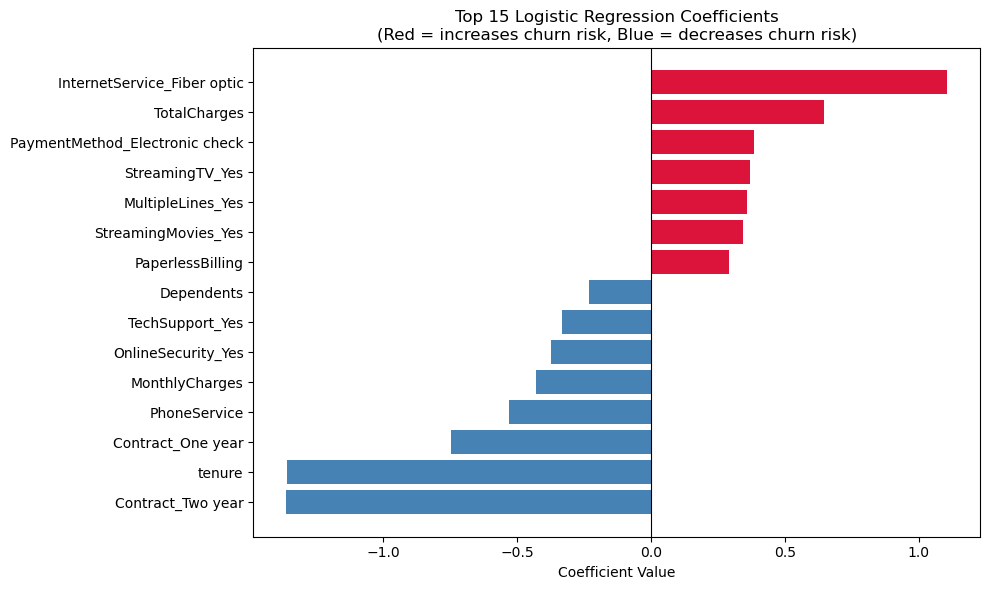

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract coefficients from Logistic Regression
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.head(15).to_string(index=False))

# Plot top 15 by absolute magnitude
top15_coef = coef_df.head(15).sort_values('Coefficient')

colors = ['crimson' if c > 0 else 'steelblue' for c in top15_coef['Coefficient']]
plt.figure(figsize=(10, 6))
plt.barh(top15_coef['Feature'], top15_coef['Coefficient'], color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Top 15 Logistic Regression Coefficients\n(Red = increases churn risk, Blue = decreases churn risk)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.savefig('lr_coefficients.png', dpi=150)
plt.show()

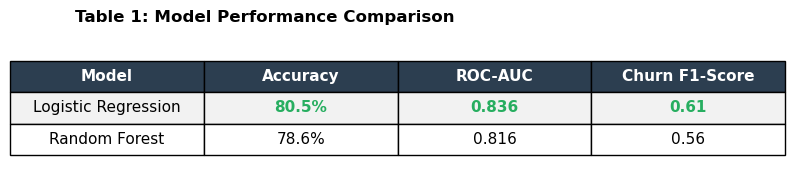

Table 1 saved.


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Data ---
table_data = [
    ['Logistic Regression', '80.5%', '0.836', '0.61'],
    ['Random Forest',       '78.6%', '0.816', '0.56']
]
col_labels = ['Model', 'Accuracy', 'ROC-AUC', 'Churn F1-Score']

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')

table = ax.table(
    cellText=table_data,
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# --- Style header row ---
for col in range(len(col_labels)):
    table[0, col].set_facecolor('#2C3E50')
    table[0, col].set_text_props(color='white', fontweight='bold')

# --- Style data rows ---
row_colors = ['#f2f2f2', '#ffffff']
for row in range(1, 3):
    for col in range(len(col_labels)):
        table[row, col].set_facecolor(row_colors[row - 1])

# --- Highlight winning values in green ---
winning_cells = [(1, 1), (1, 2), (1, 3)]  # LR wins all three
for (row, col) in winning_cells:
    table[row, col].set_text_props(color='#27AE60', fontweight='bold')

ax.set_title('Table 1: Model Performance Comparison', 
             fontweight='bold', fontsize=12, pad=10, loc='left')

plt.tight_layout()
plt.savefig('table1_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Table 1 saved.")